In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pystan 
import pandas as pd
import seaborn as sns
import math
import statistics as st
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from tqdm.notebook import tqdm as tqdm
from scipy.stats import gamma

In [2]:
#### Data Import
datum_Solid = pd.read_csv('Data/Gastric Data/Solid Retention.csv')
print(datum_Solid)
datum_Liquid = pd.read_csv('Data/Gastric Data/Liquid Retention.csv')
print(datum_Solid)
datum_Milk = pd.read_csv('Data/Gastric Data/Milk Retention.csv')
print(datum_Milk)

    Time  Retention
0      0   0.985034
1      1   0.983673
2      2   1.002721
3      3   0.989116
4      4   0.993197
..   ...        ...
85    85   0.519728
86    86   0.499320
87    87   0.492517
88    88   0.465306
89    89   0.454422

[90 rows x 2 columns]
    Time  Retention
0      0   0.985034
1      1   0.983673
2      2   1.002721
3      3   0.989116
4      4   0.993197
..   ...        ...
85    85   0.519728
86    86   0.499320
87    87   0.492517
88    88   0.465306
89    89   0.454422

[90 rows x 2 columns]
   Time  Retention
0     0   1.000000
1    10   0.835214
2    20   0.740406
3    30   0.677201
4    40   0.514673
5    50   0.483070
6    60   0.356659
7    70   0.252822


In [3]:
model = """
data {
    int N;
    real<lower=0> t[N];
    real Retention[N];
}

parameters {
    real<lower=0, upper=15> alpha; 
    real logbeta;    
    real<lower=0> sigma;    
}

model {
    sigma ~ cauchy(0, 0.1);
    for(n in 1:N) {
        Retention[n] ~ normal(1-gamma_cdf(t[n], alpha, 10^logbeta), sigma);
    }
}

generated quantities {
    real<lower=0> beta;
    beta = 10^logbeta;
}

"""
sm_retention = pystan.StanModel(model_code=model)

with open('stan_model_Retention_time.pkl', 'wb') as g:

    pickle.dump(sm_retention, g)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_30fc9d05df835e5dca4b0bd0c56c5673 NOW.


In [3]:
sm_retention = pickle.load(open('stan_model_Retention_time.pkl', 'rb'))

In [4]:
fit_nuts_Liquid_retention = sm_retention.sampling(
    data=dict(t = datum_Liquid["Time"], Retention = datum_Liquid["Retention"], N = len(datum_Liquid["Time"])), 
    iter=5000, chains=4, thin=1, warmup=2500, seed=19941023, control=dict(adapt_delta=0.95, max_treedepth=15)
    ) 

In [5]:
fit_nuts_Solid_retention = sm_retention.sampling(
    data=dict(t = datum_Solid["Time"], Retention = datum_Solid["Retention"], N = len(datum_Solid["Time"])), 
    iter=5000, chains=4, thin=1, warmup=2500, seed=19941023, control=dict(adapt_delta=0.95, max_treedepth=15)
    ) 

In [6]:
fit_nuts_Milk_retention = sm_retention.sampling(
    data=dict(t = datum_Milk["Time"], Retention = datum_Milk["Retention"], N = len(datum_Milk["Time"])), 
    iter=5000, chains=4, thin=1, warmup=2500, seed=19941023, control=dict(adapt_delta=0.95, max_treedepth=15)
    ) 

In [7]:
print(fit_nuts_Liquid_retention)
samples = fit_nuts_Liquid_retention.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts_Liquid_retention.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts_Liquid_retention.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts_Liquid_retention.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts_Liquid_retention.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)

Inference for Stan model: anon_model_30fc9d05df835e5dca4b0bd0c56c5673.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.86  4.5e-4   0.03   0.81   0.84   0.86   0.87   0.91   3171    1.0
logbeta  -1.73  2.9e-4   0.02  -1.76  -1.74  -1.73  -1.72   -1.7   3135    1.0
sigma     0.03  3.2e-5 2.2e-3   0.02   0.03   0.03   0.03   0.03   4630    1.0
beta      0.02  1.3e-5 7.1e-4   0.02   0.02   0.02   0.02   0.02   3138    1.0
lp__    273.24    0.02   1.26 270.04 272.66 273.55 274.17 274.68   3083    1.0

Samples were drawn using NUTS at Thu Jul 29 11:08:33 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


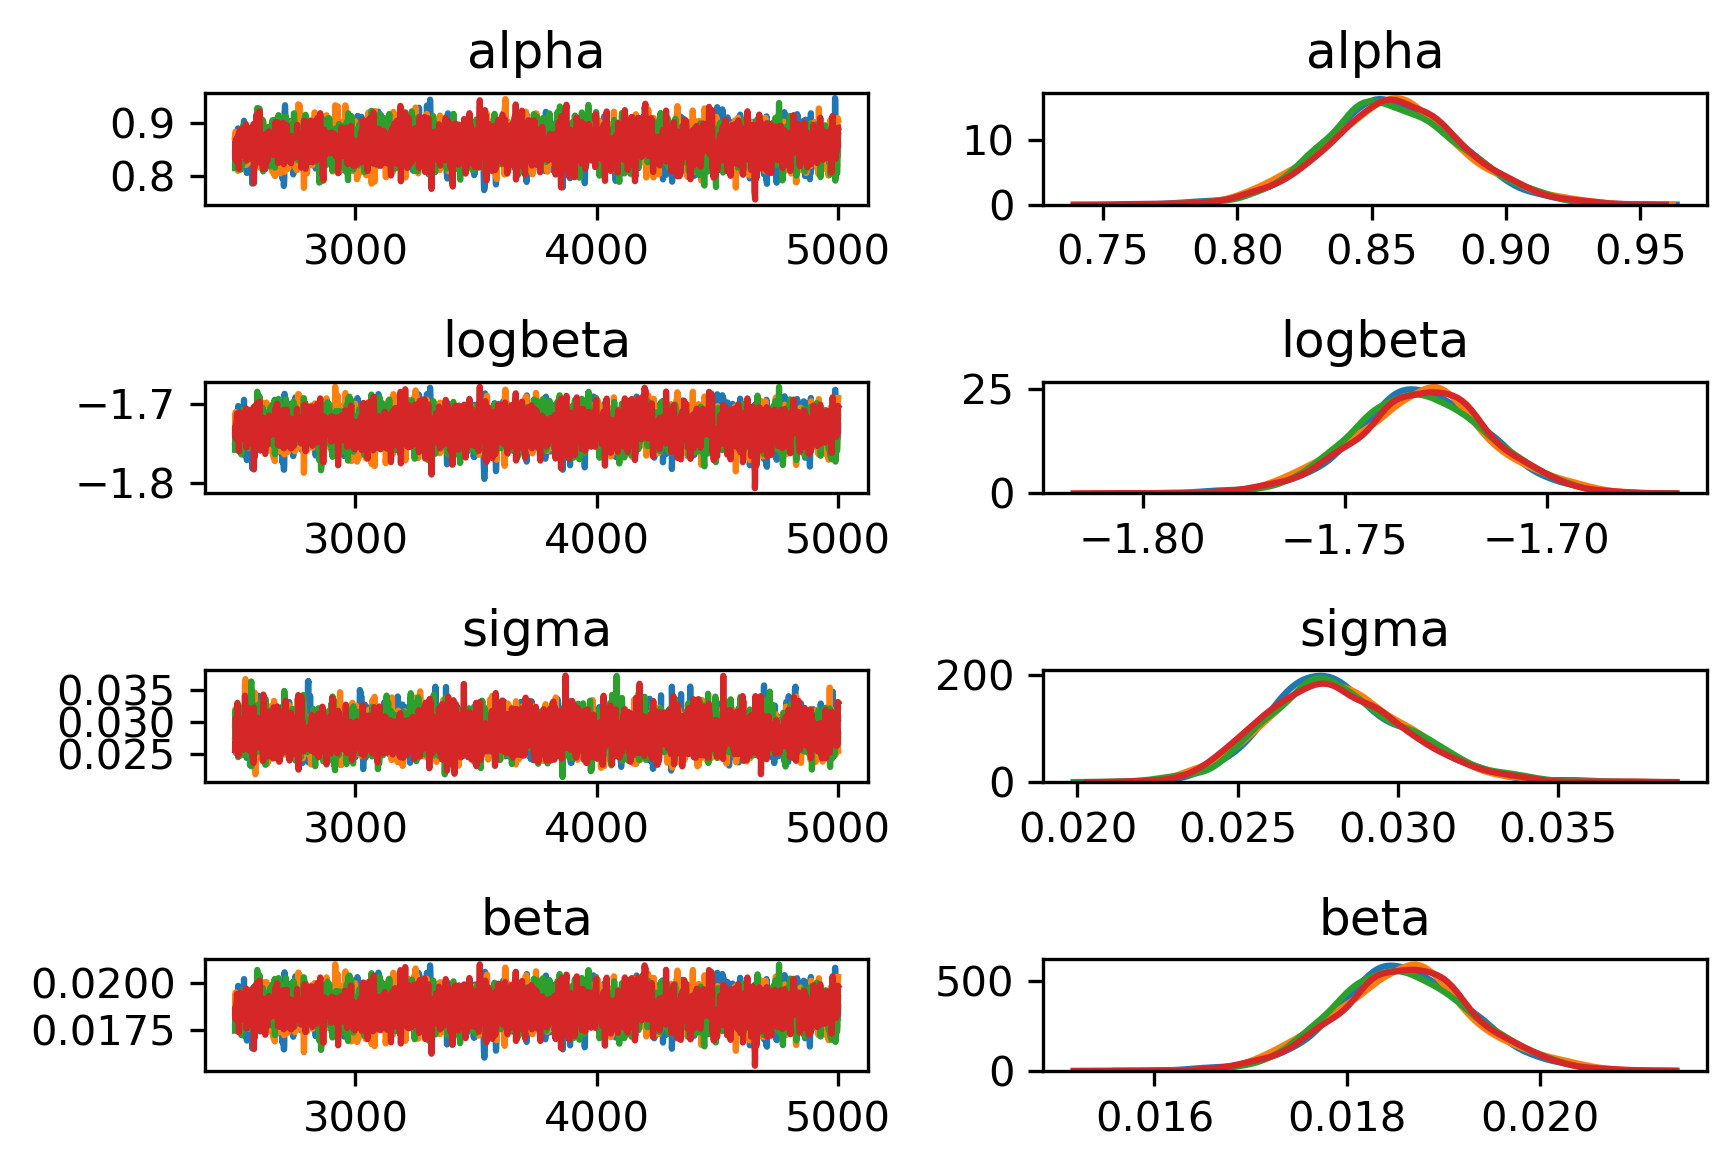

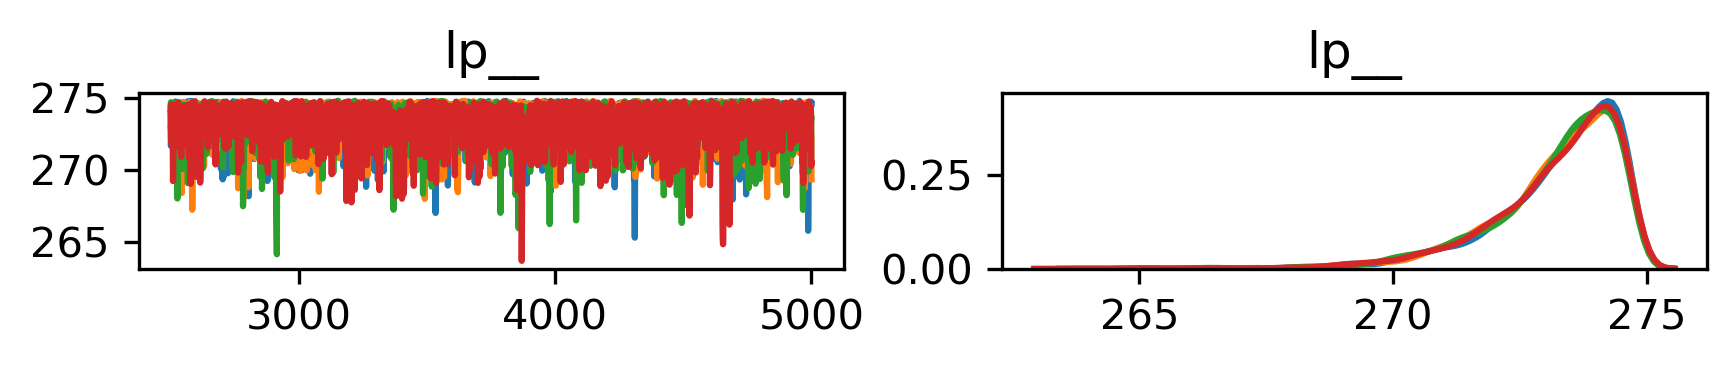

In [8]:
for pg in range(num_pages):
    plt.figure(dpi=300)
    pdf = PdfPages("Gastric Reduction/plot/traceplot/Bayesian Fitting Trace for Liquid Retention time"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [10]:
print(fit_nuts_Solid_retention)
samples = fit_nuts_Solid_retention.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts_Solid_retention.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts_Solid_retention.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts_Solid_retention.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts_Solid_retention.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)

Inference for Stan model: anon_model_30fc9d05df835e5dca4b0bd0c56c5673.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     8.39  9.3e-3   0.49   7.48   8.06   8.38    8.7   9.41   2746    1.0
logbeta  -1.03  5.4e-4   0.03  -1.09  -1.05  -1.03  -1.01  -0.97   2774    1.0
sigma     0.03  3.6e-5 2.0e-3   0.02   0.02   0.03   0.03   0.03   3072    1.0
beta      0.09  1.2e-4 6.1e-3   0.08   0.09   0.09    0.1   0.11   2729    1.0
lp__    284.78    0.03   1.31 281.33 284.22 285.13 285.72 286.24   2741    1.0

Samples were drawn using NUTS at Thu Jul 29 10:39:30 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


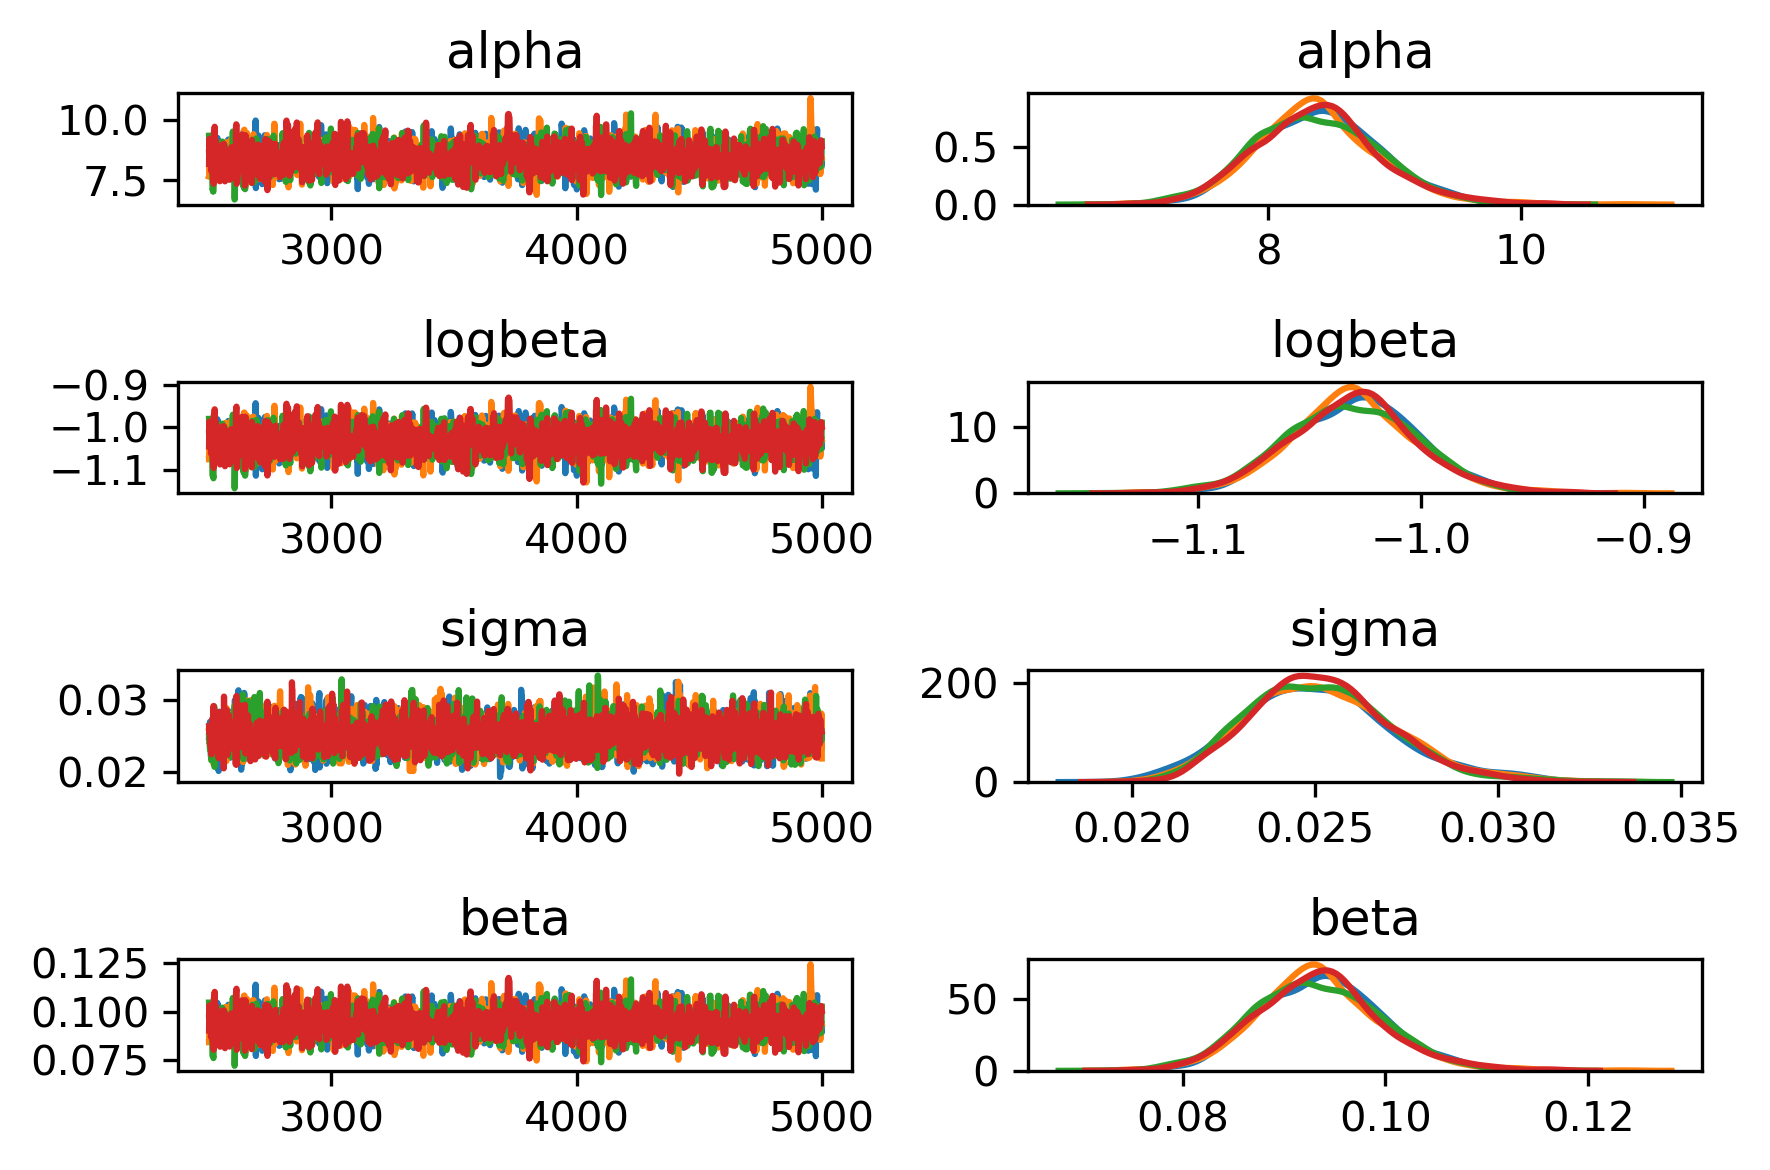

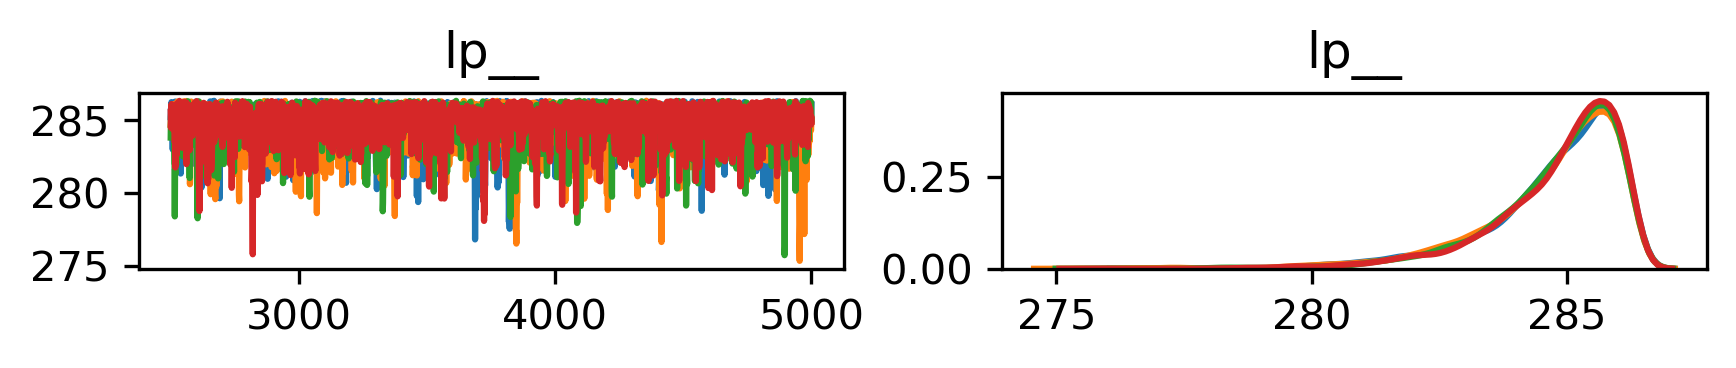

In [11]:
for pg in range(num_pages):
    plt.figure(dpi=300)
    pdf = PdfPages("Gastric Reduction/plot/traceplot/Bayesian Fitting Trace for Solid Retention time"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [12]:
print(fit_nuts_Milk_retention)
samples = fit_nuts_Milk_retention.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts_Milk_retention.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts_Milk_retention.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts_Milk_retention.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts_Milk_retention.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)

Inference for Stan model: anon_model_30fc9d05df835e5dca4b0bd0c56c5673.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     1.28  7.8e-3   0.31   0.82    1.1   1.24   1.41   1.94   1579    1.0
logbeta  -1.67  2.8e-3   0.12  -1.91  -1.73  -1.66   -1.6  -1.42   1935    1.0
sigma     0.05  4.3e-4   0.02   0.03   0.04   0.04   0.05   0.09   1725    1.0
beta      0.02  1.7e-4 6.9e-3   0.01   0.02   0.02   0.03   0.04   1629    1.0
lp__     18.04    0.04   1.57  14.01  17.37  18.46  19.16  19.79   1562    1.0

Samples were drawn using NUTS at Thu Jul 29 10:39:34 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


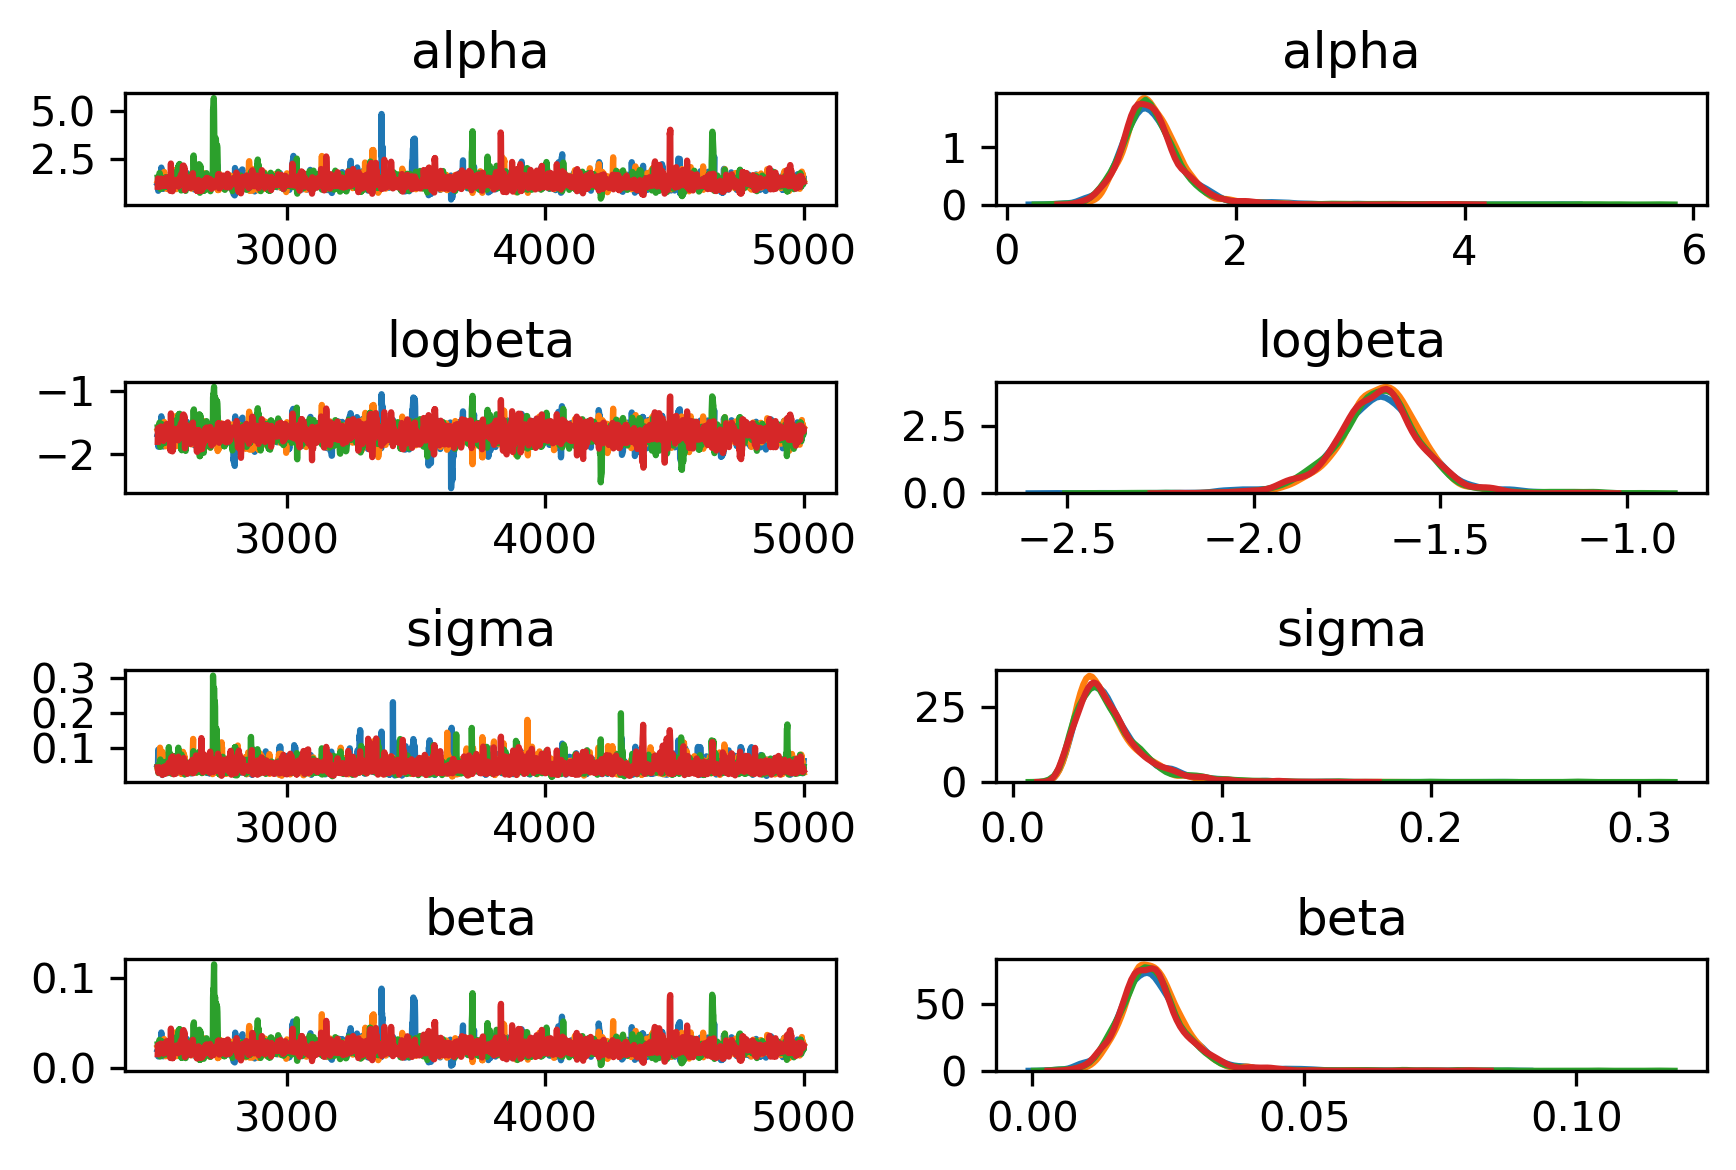

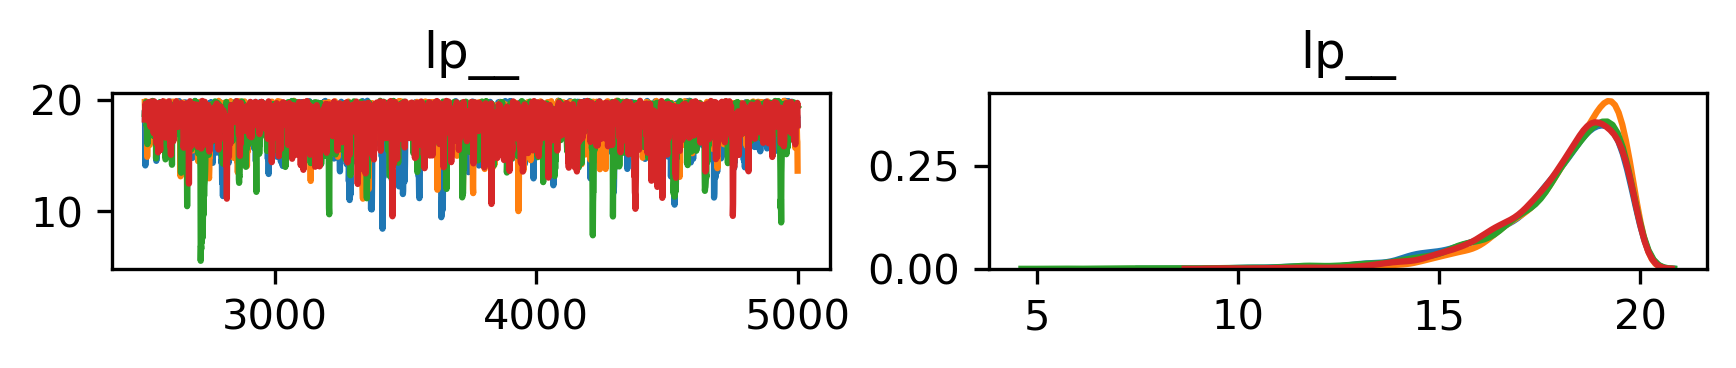

In [13]:
for pg in range(num_pages):
    plt.figure(dpi=300)
    pdf = PdfPages("Gastric Reduction/plot/traceplot/Bayesian Fitting Trace for Milk Retention time"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [14]:
with open('fit_nuts_Solid_Retention_time.pkl', 'wb') as g:

    pickle.dump(fit_nuts_Solid_retention, g)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
with open('fit_nuts_Liquid_Retention_time.pkl', 'wb') as g:

    pickle.dump(fit_nuts_Liquid_retention, g)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
with open('fit_nuts_Milk_Retention_time.pkl', 'wb') as g:

    pickle.dump(fit_nuts_Milk_retention, g)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
samples_Liquid_retention = fit_nuts_Liquid_retention.extract(permuted=True)
samples_Solid_retention = fit_nuts_Solid_retention.extract(permuted=True)
samples_Milk_retention = fit_nuts_Milk_retention.extract(permuted=True)

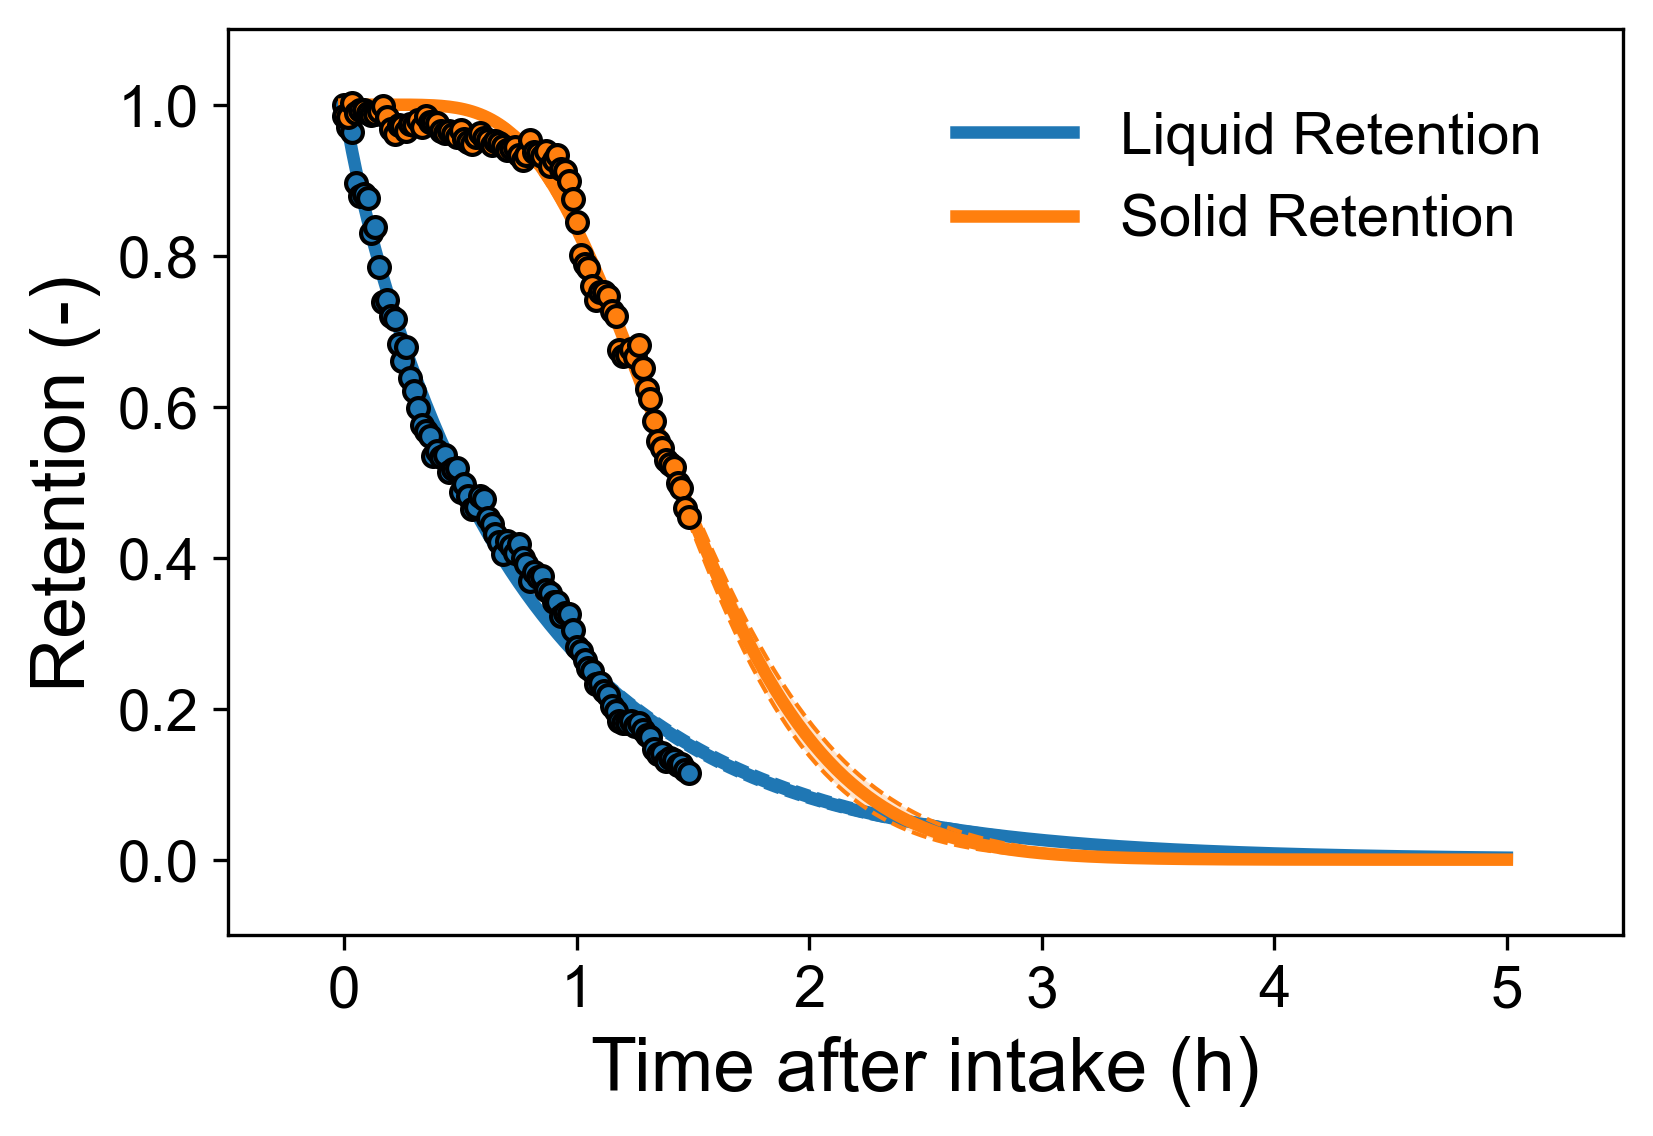

In [27]:
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
Palette=sns.color_palette(n_colors=3)
x =  np.zeros((301, 1), dtype=float)
x[:,0] = np.linspace(0, 5, 301)
for i in tqdm(range(len(samples_Liquid_retention["lp__"])),desc='Progress', leave=False):
    alpha = samples_Liquid_retention["alpha"][i]
    beta = samples_Liquid_retention["beta"][i]
    sigma = samples_Liquid_retention["sigma"][i]
    #Liquid_retention = np.random.normal(1-gamma.cdf(60*x, alpha, loc=0, scale=1./beta), sigma)
    Liquid_retention = 1-gamma.cdf(60*x, alpha, loc=0, scale=1./beta)
    if i == 0:
        Liquid_retention_list = Liquid_retention
    else:
        Liquid_retention_list = np.concatenate([Liquid_retention_list, Liquid_retention], axis = -1) 

Liquid_retention_quantile = np.zeros((301,7), dtype=float)

for j in tqdm(range(301),desc='Progress', leave=False):
    Liquid_retention_quantile[j,:] =  np.quantile(Liquid_retention_list[j,:],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    
plt.fill_between(x[:,0], Liquid_retention_quantile[:,1], Liquid_retention_quantile[:,5], facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], Liquid_retention_quantile[:,1], lw=1, color=Palette[0], linestyle='--')
plt.plot(x[:,0], Liquid_retention_quantile[:,5], lw=1, color=Palette[0], linestyle='--')
plt.plot(x[:,0], Liquid_retention_quantile[:,3], lw=3, color=Palette[0], label="Liquid Retention")

plt.plot(datum_Liquid["Time"]/60, datum_Liquid["Retention"], color = Palette[0], markeredgecolor="black", marker = "o",  linestyle = "none", markersize = 5)

x =  np.zeros((301, 1), dtype=float)
x[:,0] = np.linspace(0, 5, 301)
for i in tqdm(range(len(samples_Solid_retention["lp__"])),desc='Progress', leave=False):
    alpha = samples_Solid_retention["alpha"][i]
    beta = samples_Solid_retention["beta"][i]
    sigma = samples_Solid_retention["sigma"][i]
    #Solid_retention = np.random.normal(1-gamma.cdf(60*x, alpha, loc=0, scale=1./beta), sigma)
    Solid_retention = 1-gamma.cdf(60*x, alpha, loc=0, scale=1./beta)
    if i == 0:
        Solid_retention_list = Solid_retention
    else:
        Solid_retention_list = np.concatenate([Solid_retention_list, Solid_retention], axis = -1) 

Solid_retention_quantile = np.zeros((301,7), dtype=float)

for j in tqdm(range(301),desc='Progress', leave=False):
    Solid_retention_quantile[j,:] =  np.quantile(Solid_retention_list[j,:],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    
plt.fill_between(x[:,0], Solid_retention_quantile[:,1], Solid_retention_quantile[:,5], facecolor=Palette[1], alpha=0.2)
plt.plot(x[:,0], Solid_retention_quantile[:,1], lw=1, color=Palette[1], linestyle='--')
plt.plot(x[:,0], Solid_retention_quantile[:,5], lw=1, color=Palette[1], linestyle='--')
plt.plot(x[:,0], Solid_retention_quantile[:,3], lw=3, color=Palette[1], label="Solid Retention")

plt.plot(datum_Solid["Time"]/60, datum_Solid["Retention"], color = Palette[1], marker = "o", markeredgecolor="black", linestyle = "none", markersize = 5)

plt.ylabel("Retention (-)",size=18,fontname="Arial")
plt.xlabel("Time after intake (h)",size=18,fontname="Arial")
plt.legend(loc='upper right', borderaxespad=1, fontsize=14, frameon = False)
plt.xlim(-0.5, 5.5)
plt.ylim(-0.1, 1.1)
plt.show()

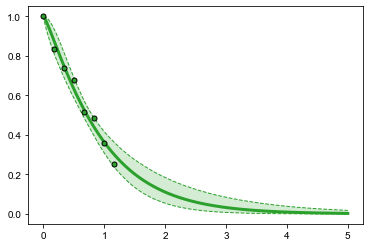

In [19]:
x =  np.zeros((301, 1), dtype=float)
x[:,0] = np.linspace(0, 5, 301)
for i in tqdm(range(len(samples_Milk_retention["lp__"])),desc='Progress', leave=False):
    alpha = samples_Milk_retention["alpha"][i]
    beta = samples_Milk_retention["beta"][i]
    sigma = samples_Milk_retention["sigma"][i]
    #Milk_retention = np.random.normal(1-gamma.cdf(60*x, alpha, loc=0, scale=1./beta), sigma)
    Milk_retention = 1-gamma.cdf(60*x, alpha, loc=0, scale=1./beta)
    if i == 0:
        Milk_retention_list = Milk_retention
    else:
        Milk_retention_list = np.concatenate([Milk_retention_list, Milk_retention], axis = -1) 

Milk_retention_quantile = np.zeros((301,7), dtype=float)

for j in tqdm(range(301),desc='Progress', leave=False):
    Milk_retention_quantile[j,:] =  np.quantile(Milk_retention_list[j,:],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    
plt.fill_between(x[:,0], Milk_retention_quantile[:,1], Milk_retention_quantile[:,5], facecolor=Palette[2], alpha=0.2)
plt.plot(x[:,0], Milk_retention_quantile[:,1], lw=1, color=Palette[2], linestyle='--')
plt.plot(x[:,0], Milk_retention_quantile[:,5], lw=1, color=Palette[2], linestyle='--')
plt.plot(x[:,0], Milk_retention_quantile[:,3], lw=3, color=Palette[2], label="Milk Retention")

plt.plot(datum_Milk["Time"]/60, datum_Milk["Retention"], color = Palette[2], marker = "o", markeredgecolor="black", linestyle = "none", markersize = 5)


Max retention time7.499280767018118


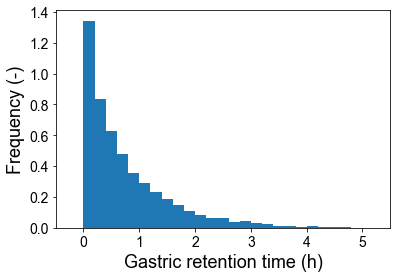

In [20]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
samples_Liquid_retention = fit_nuts_Liquid_retention.extract(permuted=True)
Num_mcmc_Retention_time = len(samples_Liquid_retention["lp__"])
dist_sim_retention_time_hour=[]
for i in tqdm(range(10**4),desc='Progress', leave=False):
    random_choice_number = random.choice(range(Num_mcmc_Retention_time))
    sim_retention_time_hour = np.random.gamma(
        samples_Liquid_retention["alpha"][random_choice_number],
        1/samples_Liquid_retention["beta"][random_choice_number])/60
    dist_sim_retention_time_hour.append(sim_retention_time_hour)

dist_sim_retention_time_hour.sort()
plt.hist(dist_sim_retention_time_hour,bins=25,density=True,range=(0,5),color=Palette[0])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=18,fontname="Arial")
np.median(dist_sim_retention_time_hour)
plt.xlim(-0.5, 5.5)

print("Max retention time"+str(np.max(dist_sim_retention_time_hour)))

with open('dist_sim_retention_time_Liquid_hour.pkl', 'wb') as f:

    pickle.dump(dist_sim_retention_time_hour, f)

In [21]:
np.mean(dist_sim_retention_time_hour)

0.7687231224434344

In [22]:
np.std(dist_sim_retention_time_hour)

0.8268154011729523

Max retention time3.8227254745638297


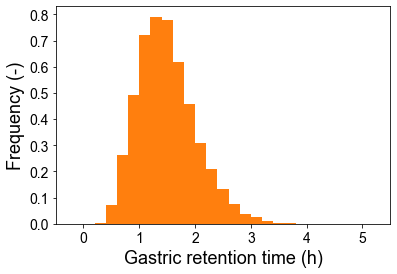

In [23]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
samples_Solid_retention = fit_nuts_Solid_retention.extract(permuted=True)
Num_mcmc_Retention_time = len(samples_Solid_retention["lp__"])
dist_sim_retention_time_hour=[]
for i in tqdm(range(10**4),desc='Progress', leave=False):
    random_choice_number = random.choice(range(Num_mcmc_Retention_time))
    sim_retention_time_hour = np.random.gamma(
        samples_Solid_retention["alpha"][random_choice_number],
        1/samples_Solid_retention["beta"][random_choice_number])/60
    dist_sim_retention_time_hour.append(sim_retention_time_hour)

dist_sim_retention_time_hour.sort()
plt.hist(dist_sim_retention_time_hour,bins=25,density=True,range=(0,5),color=Palette[1])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=18,fontname="Arial")
np.median(dist_sim_retention_time_hour)
plt.xlim(-0.5, 5.5)

print("Max retention time"+str(np.max(dist_sim_retention_time_hour)))

with open('dist_sim_retention_time_Solid_hour.pkl', 'wb') as f:

    pickle.dump(dist_sim_retention_time_hour, f)

In [24]:
np.mean(dist_sim_retention_time_hour)

1.4956306475341368

In [25]:
np.std(dist_sim_retention_time_hour)

0.5167935646335367

Max retention time15.446597073664801


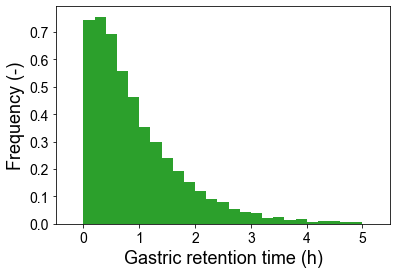

In [26]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
samples_Milk_retention = fit_nuts_Milk_retention.extract(permuted=True)
Num_mcmc_Retention_time = len(samples_Milk_retention["lp__"])
dist_sim_retention_time_hour=[]
for i in tqdm(range(10**4),desc='Progress', leave=False):
    random_choice_number = random.choice(range(Num_mcmc_Retention_time))
    sim_retention_time_hour = np.random.gamma(
        samples_Milk_retention["alpha"][random_choice_number],
        1/samples_Milk_retention["beta"][random_choice_number])/60
    dist_sim_retention_time_hour.append(sim_retention_time_hour)

dist_sim_retention_time_hour.sort()
plt.hist(dist_sim_retention_time_hour,bins=25,density=True,range=(0,5),color=Palette[2])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=18,fontname="Arial")
np.median(dist_sim_retention_time_hour)
plt.xlim(-0.5, 5.5)

print("Max retention time"+str(np.max(dist_sim_retention_time_hour)))

with open('dist_sim_retention_time_Milk_hour.pkl', 'wb') as f:

    pickle.dump(dist_sim_retention_time_hour, f)